Creative Commons CC BY 4.0 Lynd Bacon & Associates, Ltd. Not warranted to be suitable for any particular purpose. (You're on your own!)

# Boosting

Boosting algorithms are [_ensemble_ methods](https://scikit-learn.org/stable/modules/ensemble.html).  They apply a _sequence_ of algorithms, usually regression or classification learners, with the objective of improving predictive accuracy. Each learner in the sequence is trained using the results from the training of the previous learner.  Boosting ca reduce bias.


Those results used, learner by learner, depend on the nature of the boosting algorithm.  They may be the residuals resulting from the fit provided by the previous learner (as in _Gradient Boosting_), or they may be the data weighted by the prediction errors resulting from the fit of the preceding learner(_AdaBoost_).

The "learners" in the sequence are often decision trees, like CART, and they are often constrained to be small, with just a few features. 

On boosting: 

[Introduction to Statistical Learning Chapter 8](http://www-bcf.usc.edu/~gareth/ISL/)  
[A Gentle Introduction to Boosting](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)  

In the following we apply gradient boosting and AdaBoost.

참고) 
Ensenble
- Voting Classifier
- Bagging(=bootstrap aggregating) e.g. Random forest
- Bootstrap
- Pasting

![ensenble](https://t1.daumcdn.net/cfile/tistory/995D67335C46BA4114)

# Getting Packages

(There may be things here that we don't use.  Apologies.)

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, Markdown
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import linear_model
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
import pickle
import os
import shelve
%matplotlib inline


# Gradient Boosting: Tree-Based Classification

Like almost all other ML methods, Boosting methods have parameters that can be used for tuning performance.  When trees are boosted, the parameters include number of trees, a parameter that controls how quickly learning occurs across the trees, and the number of splits a tree can have.  The latter is often small, and may even be 1, in which case the tree is a _stump_.  

In the following we're going to use the cervical CA data again. We'll apply [scikit-learn's GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier).

## Getting the Data

In [6]:
# A DataFrame from the shelve db.  Adjust path as may be required.
with shelve.open('cervical') as sdb:
    cervical2=sdb['cervical2']  # this should be, too

In [7]:
X=cervical2.iloc[:,1:].to_numpy()
y=cervical2.iloc[:,0].to_numpy()
feat_nams=cervical2.columns.to_list()[1:]  # could need these

## Simple Train, Test Split

In [8]:
## Simple Validation Split.  We'll try to balance the target variable labels in train and test.

skf1=StratifiedShuffleSplit(n_splits=1,random_state=99) # Note, just a single random split here
for trainNdx,testNdx in skf1.split(X,y):
    Xtrain=X[trainNdx]
    ytrain=y[trainNdx]
    Xtest=X[testNdx]
    ytest=y[testNdx]


## Select Some Parameter Values

Let's use "tiny" trees which will be "weak" learners. Maximum depth of 1 split.  300 "stumps."  
Amongst the parameters of this boosting classifier, note the _warm_start_ option.  Setting it to True will allow adding additional trees to a trained classifier.

In [9]:
treeBoosts = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=1, random_state=99)

In [10]:
treeBoostsF=treeBoosts.fit(Xtrain, ytrain)
ypred = treeBoostsF.predict(Xtest)
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        63
           1       0.00      0.00      0.00         5

   micro avg       0.93      0.93      0.93        68
   macro avg       0.46      0.50      0.48        68
weighted avg       0.86      0.93      0.89        68



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


See [Classification Report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report) for details about the above metrics.

# UDU: Graph the Feature Importances for the Classifier Above

# UDU: Grid Search for a Better Boosted Tree Classifier

Do a grid search to see if  you can get a better model than the above.  Metrics to explore include the learning rate (try varying above and below 0.1), max_depth (try increasing to 2 and 3).

# UDU: Early Stopping

One way to avoid overfitting is to stop training when an algorithm's fit on test data is no longer improving. The algorithm used above is one of those that has a feature that will end training when a criterion is reached, which are several.  For example, the "n_iter_no_change" parameter can be used to specify that training should stop when the validation score being used isn't changing for this many iterations.  

Try setting n_iter_no_change to some small integer, like 10, and then run and evaluate the above classifer.

# Gradient Boosting: Tree-Based Classification Take 2: Different Data

Let's use the data set `dataset_37_diabetes.csv`.  It has one binary target, `class`, coded "tested_positive" and "tested_negative" for disease, and eight "features."

## Getting the Data, Munging It

In [11]:
diabetes=pd.read_csv('../DATA/ML/dataset_37_diabetes.csv')

In [12]:
diabetes.isna().sum().sum()   # number of missing values

0

In [13]:
# What are those class labels?

diabetes['class'].unique()

array(['tested_positive', 'tested_negative'], dtype=object)

Weird.

Let's recode the target variable into a 0,1 variable we'll call "target".  It's currently str data type

In [14]:
diabetes['target']=np.where(diabetes['class']=="tested_positive",1,0)
diabetes.target.unique()
diabetes.drop('class',axis=1,inplace=True)

array([1, 0])

In [15]:
# Let's check the other dtypes:

diabetes.dtypes

preg        int64
plas        int64
pres        int64
skin        int64
insu        int64
mass      float64
pedi      float64
age         int64
target      int64
dtype: object

In [16]:
# Target label counts

diabetes.target.value_counts()

0    500
1    268
Name: target, dtype: int64

In [23]:
diabetes.tail()

,preg,plas,pres,skin,insu,mass,pedi,age,target
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [39]:
## Convert to np arrays

X=diabetes.iloc[:,:8].to_numpy()
y=diabetes.iloc[:,8].to_numpy()
X.shape
y.shape

(768, 8)

(768,)

In [40]:
## Training and test split
skf1=StratifiedShuffleSplit(n_splits=1,random_state=99) # Note, just a single random split here
for trainNdx,testNdx in skf1.split(X,y):
    Xtrain=X[trainNdx]
    ytrain=y[trainNdx]
    Xtest=X[testNdx]
    ytest=y[testNdx]


In [41]:
treeBoosts = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=1, random_state=99)

In [42]:
treeBoostsFit=treeBoosts.fit(Xtrain, ytrain)
ypred = treeBoostsFit.predict(Xtest)
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.74      0.52      0.61        27

   micro avg       0.77      0.77      0.77        77
   macro avg       0.76      0.71      0.72        77
weighted avg       0.76      0.77      0.75        77



## ROC, AUC

In [43]:
ypredProb=treeBoostsFit.predict_proba(Xtest)

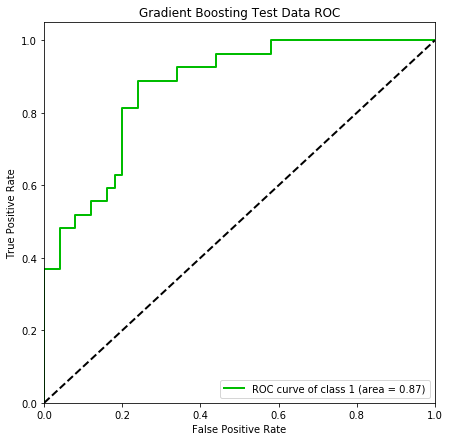

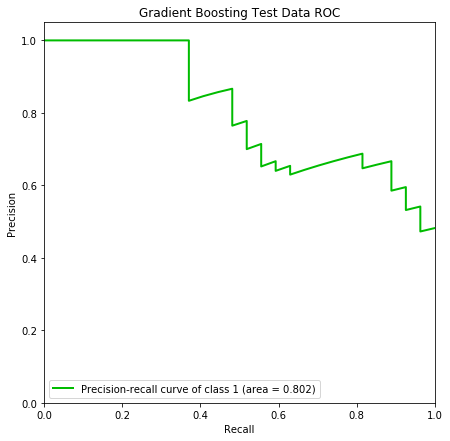

In [44]:
skplt.metrics.plot_roc(ytest, ypredProb, title="Gradient Boosting Test Data ROC",
                      figsize=(7,7),
                      plot_micro=False,
                      plot_macro=False,
                      classes_to_plot=1);
skplt.metrics.plot_precision_recall(ytest, ypredProb, title="Gradient Boosting Test Data ROC",
                      figsize=(7,7),
                      plot_micro=False,
                      classes_to_plot=1);


## GridsearchCV

In [48]:
param_grid = {'n_estimators':[300,400,500], 
             'learning_rate':[0.01, 0.1, 1],
             'max_depth':[1,2,3]}
grid=GridSearchCV(treeBoosts,param_grid=param_grid,cv=20)
grid.fit(Xtrain,ytrain)
print("Best cross-validation accuracy: {:.4f}".format(grid.best_score_))
print("Test set score: {:.4f}".format(grid.score(Xtest, ytest)))
print("Best parameters: {}".format(grid.best_params_))   

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [300, 400, 500], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best cross-validation accuracy: 0.7728
Test set score: 0.7792
Best parameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300}


In [51]:
bestgrid = GradientBoostingClassifier(**grid.best_params_)
bestgrid.fit(Xtrain,ytrain)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

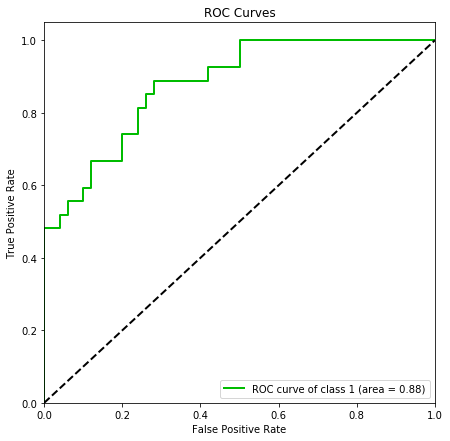

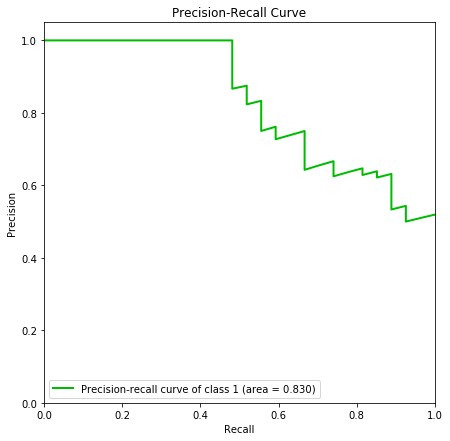

In [74]:
bestgrid.score(Xtest,ytest)
skplt.metrics.plot_roc(ytest, bestgrid.predict_proba(Xtest),
                      figsize=(7,7),
                      plot_micro=False,
                      plot_macro=False,
                      classes_to_plot=1);
skplt.metrics.plot_precision_recall(ytest, bestgrid.predict_proba(Xtest),
                      figsize=(7,7),
                      plot_micro=False,
                      classes_to_plot=1);



# UDU: Plot the Features Importances for the Above Boosted Classifier

# UDU: Gradient Boosting Regression

Try training a Boosted regression model using the _radon_ data.

Here's where you can find the scikit-learn documentation to do it: [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor). 

# AdaBoost Classifier

Let's give AdaBoost a try using the diabetes data.  Here's where the documentation is pm the scikit-learn site:

[AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier)

[AdaBoost](https://excelsior-cjh.tistory.com/166)

In [33]:
AdaBoosts=AdaBoostClassifier(n_estimators=300,random_state=99,
                             learning_rate=0.1)
AdaBoostsFit=AdaBoosts.fit(Xtrain, ytrain)
ypred = AdaBoostsFit.predict(Xtest)
print(classification_report(ytest, ypred))


              precision    recall  f1-score   support

           0       0.79      0.88      0.83        50
           1       0.71      0.56      0.63        27

   micro avg       0.77      0.77      0.77        77
   macro avg       0.75      0.72      0.73        77
weighted avg       0.76      0.77      0.76        77



In [34]:
print('AdaBoost Feature Importances:')

AdaBoostsFit.feature_importances_

AdaBoost Feature Importances:


array([0.04666667, 0.22666667, 0.05666667, 0.01      , 0.05666667,
       0.17666667, 0.27666667, 0.15      ])

Looks about the same as the gradient boosting results?  Here's the ROC:

In [35]:
ypredProb=AdaBoostsFit.predict_proba(Xtest)

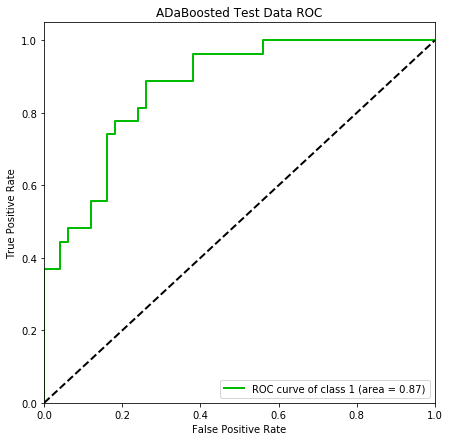

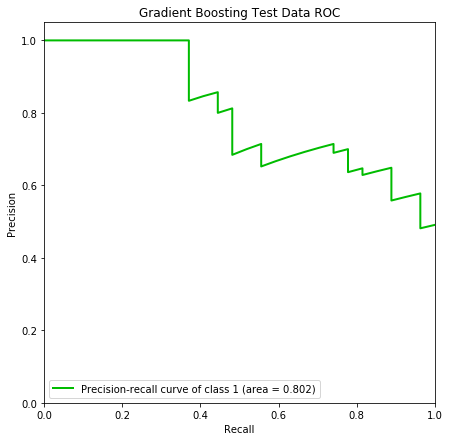

In [38]:
skplt.metrics.plot_roc(ytest, ypredProb, title="ADaBoosted Test Data ROC",
                      figsize=(7,7),
                      plot_micro=False,
                      plot_macro=False,
                      classes_to_plot=1);

skplt.metrics.plot_precision_recall(ytest, ypredProb, title="Gradient Boosting Test Data ROC",
                      figsize=(7,7),
                      plot_micro=False,
                      classes_to_plot=1);

# UDU: AdaBoosted Regression

Try training a Boosted regression model using the _radon_ data.

Here's where you can find the scikit-learn documentation to do it: [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor). 